# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [ ]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl ./

Copying gs://boolq/train.jsonl...
\ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


In [ ]:
train_path = "./train.jsonl"
dev_path = "./dev.jsonl"

In [ ]:
!pip install transformers

^C
ERROR: Operation cancelled by user


In [ ]:
import random
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb

import re

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, random_split, Subset, DataLoader, Sampler

import torch.optim as optim

import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

import gc

import json
import os
import nltk
import torch

from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.vocab import GloVe


from nltk.tokenize.stanford import StanfordTokenizer

import torch.nn as nn
import torch.nn.functional as F


from dataclasses import dataclass, field

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# зафиксируем рандомы для воспроизводимости результатов

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

In [ ]:
train_data_df = pd.read_json("train.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("dev.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

In [ ]:
questions_dev[-5:]

array(['is manic depression the same as bi polar',
       'was whiskey galore based on a true story',
       'are there plants on the international space station',
       'does the hockey puck have to cross the line to be a goal',
       'will there be a season 5 of shadowhunters'], dtype=object)

Для проверки моделей приготовим тестовыe примеры.

In [ ]:
test_passages = passages_dev[-5:]
test_questions = questions_dev[-5:]
test_answers = answers_dev[-5:]

### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

## Часть 5. BiDAF-подобная архитектура (2 балла)

Архитектура BiDAF является специфической архитектурой для QA. Здесь вам предлагается её реализовать.

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT или RoBERTa эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

Для проекта я адаптировал код BiDAF из репозитория https://github.com/galsang/BiDAF-pytorch

Подготовим данные и итераторы, используя torchtext. С описанным в статье PTBTokenizer'ом результаты были хуже. Поэтому возьмем word_tokenizer из nltk, как сделано в вышеуказанном репозитории.

In [ ]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def word_tokenize(tokens):
    return [token.replace("''", '"').replace("``", '"') for token in nltk.word_tokenize(tokens)]

In [ ]:
CHAR_NESTING = data.Field(batch_first=True, tokenize=list, lower=True)
CHAR = data.NestedField(CHAR_NESTING, tokenize=word_tokenize)
WORD = data.Field(batch_first=True, tokenize=word_tokenize, lower=True, include_lengths=True)
LABEL = data.Field(sequential=False, unk_token=None, use_vocab=False)

dict_fields = {'answer': ('answer', LABEL),
                'passage': [('c_word', WORD), ('c_char', CHAR)],
                'question': [('q_word', WORD), ('q_char', CHAR)]}

list_fields = [('answer', LABEL), 
                ('c_word', WORD), ('c_char', CHAR),
                ('q_word', WORD), ('q_char', CHAR)]

train, dev = data.TabularDataset.splits(path="",  train="./train.jsonl",
    validation="./dev.jsonl",  format='json',  fields=dict_fields)

In [ ]:
train = data.Dataset(examples=train, fields=list_fields)
dev = data.Dataset(examples=dev, fields=list_fields)
val, test = dev.split(split_ratio=0.5)

In [ ]:
d = 100
batch_size = 8
CHAR.build_vocab(train, val, test)
WORD.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=d))

train_iter = data.BucketIterator(
    train,
    batch_size=batch_size,
    device=device,
    repeat=False,
    shuffle=True,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

val_iter = data.BucketIterator(
    val,
    batch_size=batch_size,
    device=device,
    repeat=False,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

test_iter = data.BucketIterator(
    test,
    batch_size=batch_size,
    device=device,
    repeat=False,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                               
100%|█████████▉| 399999/400000 [00:26<00:00, 14845.17it/s]


In [ ]:
char_vocab_size = len(CHAR.vocab)
word_vocab_size = len(WORD.vocab)

Определим функции обучения и тестирования.

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):

        inputs = batch #.to(device)
        labels = batch.answer.float().to(device)
        optimizer.zero_grad()

        output = model(inputs).squeeze(1)

        loss = criterion(output, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        
    
        for i, batch in enumerate(iterator):
            inputs = batch #.to(device)
            labels = batch.answer.float().to(device)
            output = model(inputs).squeeze(1)
            loss = criterion(output, labels)
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def test (model, weights='best-val-model.pt', iterator=test_iter):
    model.load_state_dict(torch.load(weights))
    model.eval()
    test_acc = 0
    test_f1 = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            inputs = batch
            labels = batch.answer.float().cpu().numpy()
            output = model(inputs).squeeze(1).cpu().detach().numpy() > 0.5
            test_acc += accuracy_score(labels, output)
            test_f1 += f1_score(labels, output)
    return (test_acc / (i + 1), test_f1 / (i + 1))

In [ ]:
def train_epochs (clf, train_loader, valid_loader, optimizer, criterion, scheduler, CLIP=1, N_EPOCHS=3, patience=3):
    
    train_history = []
    valid_history = []
    
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        torch.cuda.empty_cache()
        gc.collect()

        start_time = time.time()
        
        train_loss = train(clf, train_loader, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
        
        torch.cuda.empty_cache()
        gc.collect()
        
        valid_loss = evaluate(clf, valid_loader, criterion)
        
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
            cnt = 0
        else:
            cnt += 1

        if cnt > patience:
            break


        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return train_history, valid_history

Адаптируем модель - возьмем скрытые состояния последнего слоя lstm из  Output layer (на эту lstm подаем конкатенацию эттеншенов и выхода Modeling layer). Эти скрытые состояния пропустим через один полносвязный слой-классификатор.

In [ ]:
@dataclass
class Arguments():
  char_dim: int = 8
  char_channel_width: int = 5
  char_channel_size: int = 100 # 768 
  dropout: float = 0.2
  hidden_size: int = 100 #768 
  word_dim: int = 100 #768
  char_vocab_size: int = len(CHAR.vocab)
  word_vocab_size: int = len(WORD.vocab)

args = Arguments()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=False, num_layers=1, bidirectional=False, dropout=0.2):
        super(LSTM, self).__init__()

        self.rnn = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=batch_first)

        self.dropout = nn.Dropout(p=dropout)



    def forward(self, x):
        x, x_len = x
        x = self.dropout(x)

        x_len_sorted, x_idx = torch.sort(x_len, descending=True)
        x_sorted = x.index_select(dim=0, index=x_idx)
        _, x_ori_idx = torch.sort(x_idx)

        x_packed = nn.utils.rnn.pack_padded_sequence(x_sorted, x_len_sorted.to('cpu'), batch_first=True)
        x_packed, (h, c) = self.rnn(x_packed)

        x = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)[0]
        x = x.index_select(dim=0, index=x_ori_idx)
        h = h.permute(1, 0, 2).contiguous().view(-1, h.size(0) * h.size(2)).squeeze()
        h = h.index_select(dim=0, index=x_ori_idx)

        return x, h


class Linear(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.0):
        super(Linear, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
        if dropout > 0:
            self.dropout = nn.Dropout(p=dropout)
        self.reset_params()

    def reset_params(self):
        nn.init.kaiming_normal_(self.linear.weight)
        nn.init.constant_(self.linear.bias, 0)

    def forward(self, x):
        if hasattr(self, 'dropout'):
            x = self.dropout(x)
        x = self.linear(x)
        return x

class BiDAF2(nn.Module):
    def __init__(self, args, pretrained):
        super(BiDAF2, self).__init__()
        self.args = args

        # 1. Character Embedding Layer
        self.char_emb = nn.Embedding(args.char_vocab_size, args.char_dim, padding_idx=1)
        # self.char_emb = nn.Embedding.from_pretrained(pretrained, freeze=True)
        nn.init.uniform_(self.char_emb.weight, -0.001, 0.001)

        self.char_conv = nn.Sequential(
            nn.Conv2d(1, args.char_channel_size, (args.char_dim, args.char_channel_width)),
            nn.ReLU()
            )

        # 2. Word Embedding Layer
        # initialize word embedding with GloVe
        self.word_emb = nn.Embedding.from_pretrained(pretrained, freeze=True)

        # highway network
        assert self.args.hidden_size * 2 == (self.args.char_channel_size + self.args.word_dim)
        for i in range(2):
            setattr(self, 'highway_linear{}'.format(i),
                    nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2),
                                  nn.ReLU()))
            setattr(self, 'highway_gate{}'.format(i),
                    nn.Sequential(Linear(args.hidden_size * 2, args.hidden_size * 2),
                                  nn.Sigmoid()))

        # 3. Contextual Embedding Layer
        self.context_LSTM = LSTM(input_size=args.hidden_size * 2,
                                 hidden_size=args.hidden_size,
                                 bidirectional=True,
                                 batch_first=True,
                                 dropout=args.dropout)

        # 4. Attention Flow Layer
        self.att_weight_c = Linear(args.hidden_size * 2, 1)
        self.att_weight_q = Linear(args.hidden_size * 2, 1)
        self.att_weight_cq = Linear(args.hidden_size * 2, 1)

        # 5. Modeling Layer
        self.LSTM1 = LSTM(input_size=args.hidden_size * 8, hidden_size=args.hidden_size,
                      bidirectional=True, batch_first=True, dropout=args.dropout)
        self.LSTM2 = LSTM(input_size=args.hidden_size * 2, hidden_size=args.hidden_size,
                      bidirectional=True, batch_first=True, dropout=args.dropout)
    
        # 6. Output Layer
        self.preclassifier = Linear(args.hidden_size * 2, args.hidden_size * 2, dropout=args.dropout)
        self.classifier = Linear(args.hidden_size * 2, 1, dropout=args.dropout)
        self.drop=nn.Dropout(p=args.dropout)
        self.sigmoid = nn.Sigmoid()

        self.lstm = LSTM(
            input_size=10 * args.hidden_size,
            hidden_size=args.hidden_size,
            bidirectional=True,
            batch_first=True,
            dropout=args.dropout
        )

        self.out = nn.Sequential(
            nn.Dropout(p=args.dropout),
            nn.Linear(2 * args.hidden_size, 1)
        )

        self.dropout = nn.Dropout(p=args.dropout)
        

    def forward(self, batch):
        
        def char_emb_layer(x):
            """
            :param x: (batch, seq_len, word_len)
            :return: (batch, seq_len, char_channel_size)
            """
            batch_size = x.size(0)
            # (batch, seq_len, word_len, char_dim)
            x = self.dropout(self.char_emb(x))
            # (batch， seq_len, char_dim, word_len)
            x = x.transpose(2, 3)
            # (batch * seq_len, 1, char_dim, word_len)
            x = x.view(-1, self.args.char_dim, x.size(3)).unsqueeze(1)
            # (batch * seq_len, char_channel_size, 1, conv_len) -> (batch * seq_len, char_channel_size, conv_len)
            x = self.char_conv(x).squeeze()
            # (batch * seq_len, char_channel_size, 1) -> (batch * seq_len, char_channel_size)
            x = F.max_pool1d(x, x.size(2)).squeeze()
            # (batch, seq_len, char_channel_size)
            x = x.view(batch_size, -1, self.args.char_channel_size)

            return x

        def highway_network(x1, x2):
            """
            :param x1: (batch, seq_len, char_channel_size)
            :param x2: (batch, seq_len, word_dim)
            :return: (batch, seq_len, hidden_size * 2)
            """
            # (batch, seq_len, char_channel_size + word_dim)
            x = torch.cat([x1, x2], dim=-1)
            for i in range(2):
                h = getattr(self, 'highway_linear{}'.format(i))(x)
                g = getattr(self, 'highway_gate{}'.format(i))(x)
                x = g * h + (1 - g) * x
            # (batch, seq_len, hidden_size * 2)
            return x

        def att_flow_layer(c, q):
            """
            :param c: (batch, c_len, hidden_size * 2)
            :param q: (batch, q_len, hidden_size * 2)
            :return: (batch, c_len, q_len)
            """
            c_len = c.size(1)
            q_len = q.size(1)

            cq = []
            for i in range(q_len):
                #(batch, 1, hidden_size * 2)
                qi = q.select(1, i).unsqueeze(1)
                #(batch, c_len, 1)
                ci = self.att_weight_cq(c * qi).squeeze()
                cq.append(ci)
            # (batch, c_len, q_len)
            cq = torch.stack(cq, dim=-1)

            # (batch, c_len, q_len)
            s = self.att_weight_c(c).expand(-1, -1, q_len) + \
                self.att_weight_q(q).permute(0, 2, 1).expand(-1, c_len, -1) + \
                cq

            # (batch, c_len, q_len)
            a = F.softmax(s, dim=2)
            # (batch, c_len, q_len) * (batch, q_len, hidden_size * 2) -> (batch, c_len, hidden_size * 2)
            c2q_att = torch.bmm(a, q)
            # (batch, 1, c_len)
            b = F.softmax(torch.max(s, dim=2)[0], dim=1).unsqueeze(1)
            # (batch, 1, c_len) * (batch, c_len, hidden_size * 2) -> (batch, hidden_size * 2)
            q2c_att = torch.bmm(b, c).squeeze()
            # (batch, c_len, hidden_size * 2) (tiled)
            q2c_att = q2c_att.unsqueeze(1).expand(-1, c_len, -1)


            # (batch, c_len, hidden_size * 8)
            x = torch.cat([c, c2q_att, c * c2q_att, c * q2c_att], dim=-1)
            return x



        # 1. Character Embedding Layer
        c_char = char_emb_layer(batch.c_char.to(device))
        q_char = char_emb_layer(batch.q_char.to(device))
        # 2. Word Embedding Layer
        c_word = self.word_emb(batch.c_word[0].to(device))
        q_word = self.word_emb(batch.q_word[0].to(device))
        c_lens = batch.c_word[1]
        q_lens = batch.q_word[1]

        # Highway network
        c = highway_network(c_char, c_word)
        q = highway_network(q_char, q_word)

        # 3. Contextual Embedding Layer        
        c = self.context_LSTM((c, c_lens))[0]
        q = self.context_LSTM((q, q_lens))[0]

        # 4. Attention Flow Layer
        g = att_flow_layer(c, q)

        # 5. Modeling Layer
        out = self.LSTM1((g, c_lens))[0]
        m = self.LSTM2((out, c_lens))[0]
        
        # 6. Output Layer
        features = self.lstm((torch.cat([g, m], dim=-1), c_lens))
        p = self.sigmoid(self.out(features[1]))
    
        return p

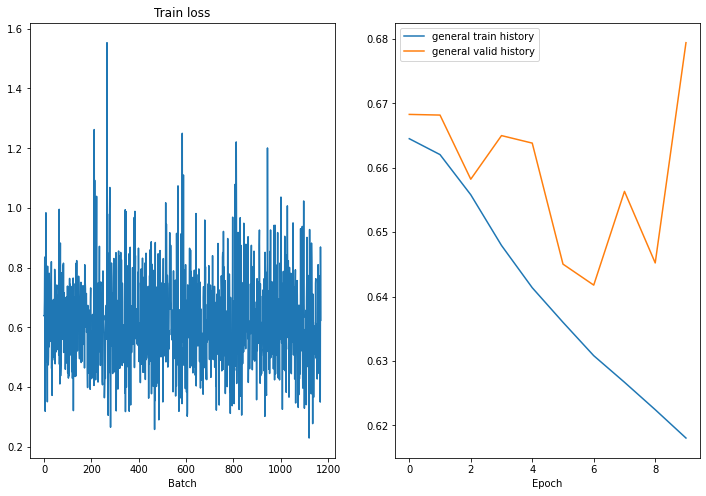

Test acc:  (0.6567073170731708, 0.7359855050098961)


In [ ]:
torch.cuda.empty_cache()
gc.collect()

n_epochs = 50
num_steps = len(train_iter) * n_epochs
args.dropout = 0.5
model = BiDAF2(args, pretrained=WORD.vocab.vectors).to(device)

no_decay = ['bias', 'LayerNorm.weight']
decay = 0.01
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = ppb.AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)

criterion = nn.BCELoss()

train_epochs (model, train_iter, val_iter, optimizer, criterion, scheduler=None, 
              CLIP=1, N_EPOCHS=n_epochs, patience=3) 
print ('Test acc: ', test(BiDAF2(args, pretrained=WORD.vocab.vectors).to(device), 
                          weights='best-val-model.pt', iterator=test_iter))

Результат - 0.6567

Проверим модель на наших примерах.

In [ ]:
model = BiDAF2(args, pretrained=WORD.vocab.vectors).to(device)
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [ ]:
def predict (model, questions, passages, answers, weights='best-val-model.pt'):
    
    examples = []
    for i in range(len(questions)):
        x = {'answer': answers[i], 'passage': passages[i], 'question': questions[i]}
        example = data.Example.fromdict(x, dict_fields)
        examples.append(example)
    our = data.Dataset(examples=examples, fields=list_fields)
    our_iter = data.BucketIterator(
    our,
    batch_size=len(our),
    device=device,
    repeat=False,
    shuffle=False,
    sort_within_batch = False
    )

    model.load_state_dict(torch.load(weights))
    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(our_iter):
            inputs = batch#.to(device)
            labels = batch.answer.float().cpu().numpy()
            output = model(inputs).squeeze(1).cpu().detach().numpy() > 0.5

    
    for i in range(len(labels)):
        print("Q.: ", questions[i])
        print("P.: ", passages[i])
        if output[i]:
            print ('YES')
        else:
            print('NO')

In [ ]:
predict (model, test_questions, test_passages, test_answers, weights='best-val-model.pt')

Q.:  is manic depression the same as bi polar
P.:  Bipolar disorder, previously known as manic depression, is a mental disorder that causes periods of depression and periods of abnormally elevated mood. The elevated mood is significant and is known as mania or hypomania, depending on its severity, or whether symptoms of psychosis are present. During mania, an individual behaves or feels abnormally energetic, happy, or irritable. Individuals often make poorly thought out decisions with little regard to the consequences. The need for sleep is usually reduced during manic phases. During periods of depression, there may be crying, a negative outlook on life, and poor eye contact with others. The risk of suicide among those with the illness is high at greater than 6 percent over 20 years, while self-harm occurs in 30--40 percent. Other mental health issues such as anxiety disorders and substance use disorder are commonly associated.
YES
Q.:  was whiskey galore based on a true story
P.:  SS 

Результат на конкретных примерах лучше, чем у предыдущих моделей - на 4 из 5 вопросов ответ правильный.

Теперь попробуем использовать эмбеддинги из BERT.

In [ ]:
args.char_channel_size = 768 
args.dropout = 0.2
args.hidden_size = 768 
args.word_dim = 768
args.char_vocab_size = len(CHAR.vocab)
args.word_vocab_size = len(WORD.vocab)

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def bert_tokenize(sen):
    return tokenizer.tokenize(sen) 

In [ ]:
CHAR_NESTING = data.Field(batch_first=True, tokenize=list, unk_token=tokenizer.unk_token)
CHAR = data.NestedField(CHAR_NESTING, tokenize=bert_tokenize)
WORD = data.Field(batch_first=True, sequential=True, tokenize=bert_tokenize, 
                  pad_token=tokenizer.pad_token, unk_token=tokenizer.unk_token,
                  include_lengths=True)
LABEL = data.Field(sequential=False, unk_token=None, use_vocab=False)

dict_fields = {'answer': ('answer', LABEL),
                'passage': [('c_word', WORD), ('c_char', CHAR)],
                'question': [('q_word', WORD), ('q_char', CHAR)]}

list_fields = [('answer', LABEL), 
                ('c_word', WORD), ('c_char', CHAR),
                ('q_word', WORD), ('q_char', CHAR)]

train_set, dev_set = data.TabularDataset.splits(path="./",  train="train.jsonl",
   validation="dev.jsonl",  format='json',  fields=dict_fields)

In [ ]:
train_dataset = data.Dataset(examples=train_set, fields=list_fields)
dev_dataset = data.Dataset(examples=dev_set, fields=list_fields)
val_dataset, test_dataset = dev_dataset.split(split_ratio=0.5)

In [ ]:
CHAR.build_vocab(train_dataset, val_dataset, test_dataset)
WORD.build_vocab(train_dataset, val_dataset, test_dataset)

WORD.vocab.stoi = tokenizer.vocab
WORD.vocab.itos = list(tokenizer.vocab)

In [ ]:
batch_size = 8


train_iter = data.BucketIterator(
    train_dataset,
    batch_size=batch_size,
    device=device,
    repeat=False,
    shuffle=True,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

val_iter = data.BucketIterator(
    val_dataset,
    batch_size=batch_size,
    device=device,
    repeat=False,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

test_iter = data.BucketIterator(
    test_dataset,
    batch_size=batch_size,
    device=device,
    repeat=False,
    sort_within_batch = True,
    sort_key=lambda x: len(x.c_word)
)

In [ ]:
char_vocab_size = len(CHAR.vocab)
word_vocab_size = len(WORD.vocab)
emb = bert.embeddings.word_embeddings.weight.data

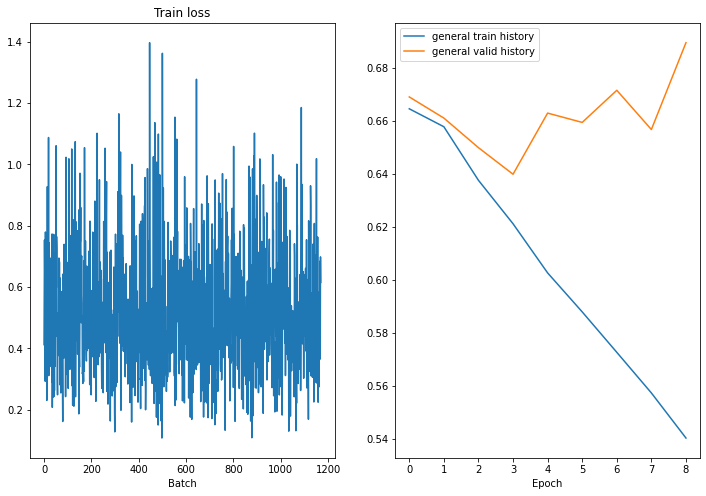

(0.6654471544715447, 0.7501050981538789)


In [ ]:
  
n_epochs = 50
num_steps = len(train_iter) * n_epochs
args.dropout = 0.5
model = BiDAF2(args, pretrained=emb).to(device)

no_decay = ['bias', 'LayerNorm.weight']
decay = 0.01
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = ppb.AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)

criterion = nn.BCELoss()

train_epochs (model, train_iter, val_iter, optimizer, criterion, scheduler=None, 
              CLIP=1, N_EPOCHS=n_epochs, patience=5) 

print(test(model, weights='best-val-model.pt', iterator=test_iter))

Результат - 0.6654

In [ ]:
predict (model, test_questions, test_passages, test_answers, weights='best-val-model.pt')

Q.:  is manic depression the same as bi polar
P.:  Bipolar disorder, previously known as manic depression, is a mental disorder that causes periods of depression and periods of abnormally elevated mood. The elevated mood is significant and is known as mania or hypomania, depending on its severity, or whether symptoms of psychosis are present. During mania, an individual behaves or feels abnormally energetic, happy, or irritable. Individuals often make poorly thought out decisions with little regard to the consequences. The need for sleep is usually reduced during manic phases. During periods of depression, there may be crying, a negative outlook on life, and poor eye contact with others. The risk of suicide among those with the illness is high at greater than 6 percent over 20 years, while self-harm occurs in 30--40 percent. Other mental health issues such as anxiety disorders and substance use disorder are commonly associated.
NO
Q.:  was whiskey galore based on a true story
P.:  SS P

При том, что метрика accuracy улучшилась, результаты на конкретном примере хуже, чем при использовании word_tokenizer.

## Часть 6. Итоги (2 балла)
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

Рассмотренные в рамках проекта подходы дали следующие показатели метрики accuracy:



*   Константное решение - 0.62
*   Использование fasttext на склейках вопросов и абзацев - 0.63
*   Обучение логистической регрессии на конкатенированных BERT-эмбеддингах вопроса и абзаца - 0.67
*   Файнтьюнинг предобученного BERTа с добавленными полносвязными слоями классификатора на конкатенации вопроса и предложения - 0.72 
*   Адаптация модели BiDAF для бинарного QA - 0.67










Лучший результат дал файнтьюнинг предобученного BERTа с добавленными полносвязными слоями классификатора на конкатенации вопроса и предложения.

В выполнении работы помогли наличие предобученных трансформеров и модели, предназначенные для развернутого (небинарного) QA. Однако, эксперименты показали, что задача бинарного QA существенно отличается от небинарного варианта (SQuAD и т.п.). Авторы датасета BoolQ в своей статье сделали аналогичный вывод. Беглый поиск подходов к решению задачи QA на BoolQ показал, что на данный момент хороших результатов в этой задаче никто не достиг.

Для выполнения проекта не хватило ресурсов бесплатных GPU-платформ (Colab, Kaggle), требуется существенно больший объем памяти GPU для использования батчей  большего размера и отказоустойчивости при проведении экспериментов. Также размер датасета BoolQ не позволяет полноценно обучать большие модели, требуется больше данных. Возможно, здесь помогла бы аугментация данных, но мне не удалось найти подходящий вариант аугментации.